In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
!pip install keras-tuner
import keras_tuner as kt
from tensorflow.keras import layers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/widsTeam_15/finalized_df_wids/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Merged_ros_df.csv  Merged_rus_df.csv  Merged_test_df.csv  Merged_train_df_unbalanced.csv


In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/widsTeam_15/finalized_df_wids/Merged_test_df.csv")
train_df = pd.read_csv("/content/drive/MyDrive/widsTeam_15/finalized_df_wids/Merged_ros_df.csv")

In [ ]:
print("NA for testing dataframe: ", test_df.isna().sum().sum())
print("NA for training dataframe: ", train_df.isna().sum().sum())
print(test_df.shape)
print(train_df.shape)

NA for testing dataframe:  0
NA for training dataframe:  0
(304, 19973)
(2124, 19975)


In [ ]:
X_train = train_df.drop(columns=['participant_id', 'ADHD_Outcome','Sex_F'])
Y_train = train_df[['ADHD_Outcome','Sex_F']]
X_test2 = test_df.drop(columns=['participant_id'])
print(X_train.shape)
print(Y_train.shape)
print(X_test2.shape)

(2124, 19972)
(2124, 2)
(304, 19972)


In [ ]:
print(train_df.columns.equals(test_df.columns))

False


In [ ]:
#reordering the columns of a dataframe to match the other to make standard scalar work
test_df= test_df.reindex(columns=train_df.columns)
print(train_df.columns.equals(test_df.columns))

True


In [ ]:
#identifying common columns
common_columns = list(set(train_df.columns) & set(test_df.columns))
print("Number of common columns:", len(common_columns))

additional_col = [ 'ADHD_Outcome','Sex_F']
# Keep only common columns in both dataframes
train_df_common = train_df[common_columns]
test_df_common = test_df[common_columns]

# Show the number of rows and columns in the dataframes with common columns
print(test_df_common.shape)
print(train_df_common.shape)

Number of common columns: 19975
(304, 19975)
(2124, 19975)


In [ ]:
X = train_df_common.drop(columns=['participant_id', 'ADHD_Outcome','Sex_F'])
Y = train_df_common[['ADHD_Outcome','Sex_F']]
print(X_train.shape)
print(Y_train.shape)
print(X_test2.shape)

(2124, 19972)
(2124, 2)
(304, 19972)


In [ ]:
Y_train.columns

Index(['ADHD_Outcome', 'Sex_F'], dtype='object')

In [ ]:
X_train, X_test, Y_train,Y_test= train_test_split(X,Y, test_size=.2, random_state=123)
#spliting further into training and validation
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train, test_size=.2,random_state=123)

In [ ]:
#standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_test)
X_test_scaled = scaler.transform(X_test)

Hyperparameter Tuning

In [ ]:
def build_model(hp):
    model_hp = keras.Sequential()

    # First hidden layer (tuning number of units)
    model_hp.add(layers.Dense(hp.Int('units_1', min_value=32, max_value=256, step=32), activation='relu'))

    # Second hidden layer (if selected, tune number of units)
    if hp.Boolean("second_layer"):
        model_hp.add(layers.Dense(hp.Int('units_2', min_value=32, max_value=128, step=32), activation='relu'))

        # Third hidden layer (if selected, tune number of units)
        if hp.Boolean("third_layer"):
            model_hp.add(layers.Dense(hp.Int('units_3', min_value=16, max_value=64, step=16), activation='relu'))

    # Output layer for binary classification
    model_hp.add(layers.Dense(2, activation="sigmoid"))

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', [0.001, 0.015, 0.01])

    # Compile the model
    model_hp.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                     loss="binary_crossentropy",
                     metrics=["binary_accuracy"])

    return model_hp


In [ ]:
#grid search
tuner = kt.RandomSearch(build_model, objective="val_binary_accuracy", max_trials=10, executions_per_trial=2, directory='my_tuning',project_name='neural_net_gridsearch')
#starting the search
tuner.search(X_train_scaled, Y_train, epochs=45, validation_split=0.2)


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of units in first layer: {best_hps.get('units_1')}")
print(f"Second layer included: {best_hps.get('second_layer')}")
print(f"Best number of units in second layer: {best_hps.get('units_2')}")
print(f"Best number of units in third layer: {best_hps.get('units_3')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Build the best model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model with training data
best_model.fit(X_train_scaled, Y_train, epochs=30, validation_data=(X_val, Y_val))

# Evaluate on test data
test_loss, test_acc = best_model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Trial 10 Complete [00h 03m 19s]
val_binary_accuracy: 0.8612132370471954

Best val_binary_accuracy So Far: 0.8612132370471954
Total elapsed time: 00h 33m 43s
Best number of units in first layer: 160
Second layer included: True
Best number of units in second layer: 96
Best number of units in third layer: 48
Best learning rate: 0.001
Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - binary_accuracy: 0.6501 - loss: 0.6149 - val_binary_accuracy: 0.4971 - val_loss: 0.9139
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - binary_accuracy: 0.9954 - loss: 0.0223 - val_binary_accuracy: 0.4853 - val_loss: 1.4403
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - binary_accuracy: 0.9992 - loss: 0.0060 - val_binary_accuracy: 0.4912 - val_loss: 1.3648
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - binary_accuracy: 1.0000 - loss: 7.4595e-04 - val_binary_accuracy: 0.4882 - val_loss: 1.4370
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - binary_accuracy: 1.0000 - loss: 5.2379e-04 - v

In [ ]:
model = Sequential()

# Input layer
input_layer = keras.layers.InputLayer(input_shape=(19972,), name='input')
model.add(input_layer)

# Hidden layers
hidden_layer_1 = keras.layers.Dense(units=64, activation='relu', name='hidden_layer_1')
model.add(hidden_layer_1)

hidden_layer_2 = keras.layers.Dense(units=32,activation='relu', name='hidden_layer_2')
model.add(hidden_layer_2)

hidden_layer_3 = keras.layers.Dense(units=16, activation='relu', name='hidden_layer_3')
model.add(hidden_layer_3)

# Output layer for binary classification
output_layer = keras.layers.Dense(units=2, activation='sigmoid', name='output')
model.add(output_layer)

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)               │ (None, 64)                  │       1,278,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_2 (Dense)               │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_3 (Dense)               │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,914 (4.89 MB)

 Trainable params: 1,280,914 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
num_epochs=30
model.compile(optimizer=Adam(learning_rate=0.015), loss='binary_crossentropy', metrics=['binary_accuracy'])
#training the model
model_hist = model.fit(X_train_scaled, Y_train, epochs=num_epochs, batch_size=32, validation_split=0.2, verbose=1)

predictions = model.predict(X_test_scaled)
train_predictions = model.predict(X_train_scaled)

predicted_ADHD = (predictions[:, 0] > 0.5).astype(int)
predicted_Sex_F = (predictions[:, 1] > 0.5).astype(int)

train_predicted_ADHD = (train_predictions[:, 0] > 0.5).astype(int)
train_predicted_Sex_F = (train_predictions[:, 1] > 0.5).astype(int)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - binary_accuracy: 0.6509 - loss: 0.5440 - val_binary_accuracy: 0.5974 - val_loss: 0.6730
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - binary_accuracy: 0.6502 - loss: 0.5453 - val_binary_accuracy: 0.6011 - val_loss: 0.7228
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.6612 - loss: 0.5544 - val_binary_accuracy: 0.6195 - val_loss: 1.7121
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - binary_accuracy: 0.6655 - loss: 0.8690 - val_binary_accuracy: 0.5956 - val_loss: 0.7464
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - binary_accuracy: 0.6430 - loss: 0.6853 - val_binary_accuracy: 0.6085 - val_loss: 1.4181
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - binary_accuracy: 0.6668 - loss: 0.5544 - val_binary_accuracy: 0.5882 - val_loss: 0.8121
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - binary_accuracy: 0.6659 - loss: 0.5232 - val_binary_accuracy: 0.6140 - val_loss: 1.7410
Epoch 8/30
34

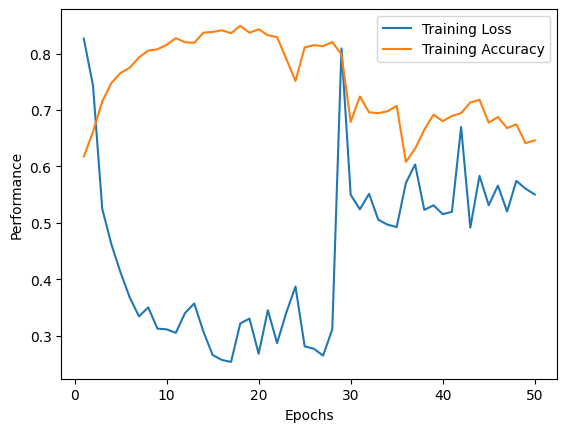

In [ ]:
plt.plot(range(1,num_epochs+1), model_hist.history['loss'], label='Training Loss')
plt.plot(range(1,num_epochs+1), model_hist.history['binary_accuracy'], label='Training Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [ ]:
#seeing how well the model is doing
from sklearn.metrics import f1_score
actual_ADHD = Y_train['ADHD_Outcome']
actual_Sex_F = Y_train['Sex_F']

adhd_f1 = f1_score(actual_ADHD, train_predicted_ADHD)
sex_f_f1 = f1_score(actual_Sex_F, train_predicted_Sex_F)

print("ADHD F1 Score: ", adhd_f1)
print("Sex F1 Score: ", sex_f_f1)


ADHD F1 Score:  0.3138780804150454
Sex F1 Score:  0.489432703003337


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


# Calculate metrics
accuracy_sex = accuracy_score(actual_Sex_F, train_predicted_Sex_F)
precision_sex = precision_score(actual_Sex_F, train_predicted_Sex_F)
recall_sex = recall_score(actual_Sex_F, train_predicted_Sex_F)

print(f"Accuracy for sex: {accuracy_sex:.2f}")
print(f"Precision for sex: {precision_sex:.2f}")
print(f"Recall for sex: {recall_sex:.2f}")


accuracy_adhd = accuracy_score(actual_ADHD, train_predicted_ADHD)
precision_adhd = precision_score(actual_ADHD, train_predicted_ADHD)
recall_adhd = recall_score(actual_ADHD, train_predicted_ADHD)
print()

print(f"Accuracy for ADHD: {accuracy_adhd:.2f}")
print(f"Precision for ADHD: {precision_adhd:.2f}")
print(f"Recall for ADHD: {recall_adhd:.2f}")



Accuracy for sex: 0.66
Precision for sex: 1.00
Recall for sex: 0.32

Accuracy for ADHD: 0.61
Precision for ADHD: 1.00
Recall for ADHD: 0.19


In [ ]:

X_test2 = X_test2.reindex(columns=X_train.columns, fill_value=0)  # Fill missing columns with 0 if needed
X_test_testdf = scaler.transform(X_test2)

predictions = model.predict(X_test_testdf)
#converting to 0 or 1 based on .5 threshold
predicted_labels = (predictions[:, 0] > 0.5).astype(int)

predicted_ADHD = predicted_labels
predicted_Sex_F = (predictions[:, 1] > 0.5).astype(int)

submission_df = pd.DataFrame({'participant_id': test_df['participant_id'],'ADHD_Outcome': predicted_ADHD,'Sex_F': predicted_Sex_F})
submission_df.to_csv('submission_ros.csv', index=False)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
